## AISE4010- Project - Traffic Congestion

### Group 7:
#### Aaron Triguero, Khen Agnes, Shiv Pi Patel



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Normalization
from keras.layers import LSTM, SimpleRNN, Conv1D, GRU
from tensorflow.keras.utils import plot_model

## View raw files for speed, occupancy, travel time

                     Occupancy
timestamp                     
2015-09-01 11:30:00      13.56
2015-09-01 11:35:00       8.33
2015-09-01 11:40:00      11.78
2015-09-01 11:55:00      15.28
2015-09-01 12:00:00      10.06


<Axes: xlabel='timestamp', ylabel='average # cars'>

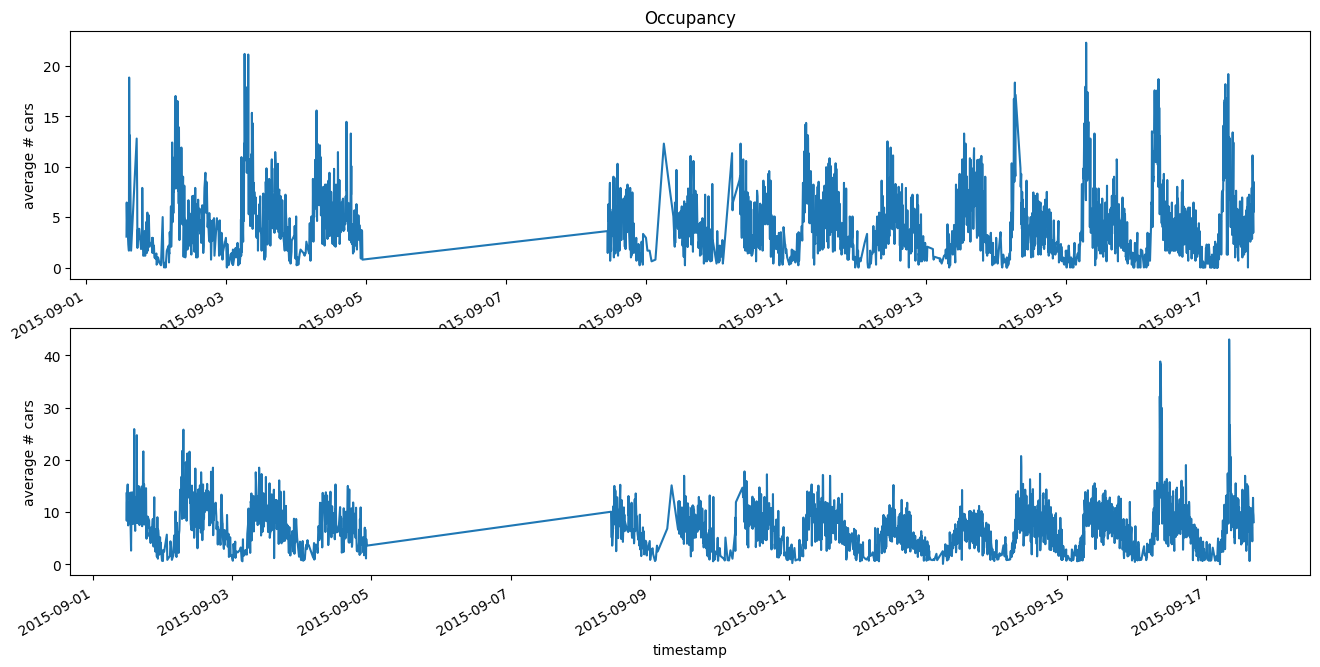

In [3]:
# Load Occupancy dataset
df_o1 = pd.read_csv('occupancy_6005.csv').rename(columns={'value':'Occupancy'})
df_o2 = pd.read_csv('occupancy_t4013.csv').rename(columns={'value':'Occupancy'})

# Set index
df_o1['timestamp'] = pd.to_datetime(df_o1['timestamp'])   # to datetime
df_o2['timestamp'] = pd.to_datetime(df_o2['timestamp'])
df_o1 = df_o1.set_index('timestamp')
df_o2 = df_o2.set_index('timestamp')
print(df_o2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
df_o1['Occupancy'].plot(ylabel='average # cars',title='Occupancy')
plt.subplot(2, 1, 2)
df_o2['Occupancy'].plot(ylabel='average # cars')

                     Travel Time
timestamp                       
2015-07-28 11:56:00          248
2015-07-28 12:06:00          178
2015-07-28 12:25:00          155
2015-07-28 13:56:00          121
2015-07-28 14:06:00          103


<Axes: xlabel='timestamp', ylabel='seconds'>

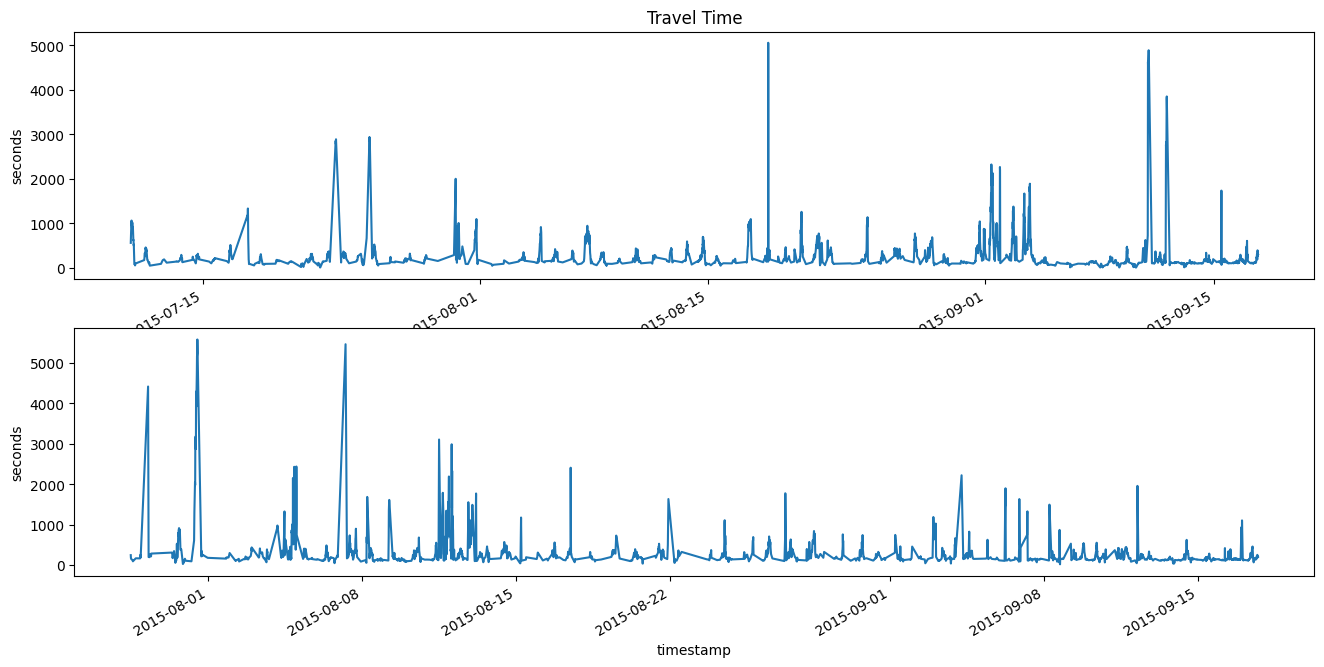

In [4]:
# Load TravelTime dataset
df_t1 = pd.read_csv('TravelTime_387.csv').rename(columns={'value':'Travel Time'})
df_t2 = pd.read_csv('TravelTime_451.csv').rename(columns={'value':'Travel Time'})

# Set index
df_t1['timestamp'] = pd.to_datetime(df_t1['timestamp'])   # to datetime
df_t2['timestamp'] = pd.to_datetime(df_t2['timestamp'])
df_t1 = df_t1.set_index('timestamp')
df_t2 = df_t2.set_index('timestamp')
print(df_t2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
df_t1['Travel Time'].plot(ylabel='seconds',title='Travel Time')
plt.subplot(2, 1, 2)
df_t2['Travel Time'].plot(ylabel='seconds')

                     Speed
timestamp                 
2015-09-01 11:25:00     58
2015-09-01 11:30:00     63
2015-09-01 11:35:00     63
2015-09-01 11:40:00     64
2015-09-01 11:55:00     58


<Axes: xlabel='timestamp', ylabel='km/h'>

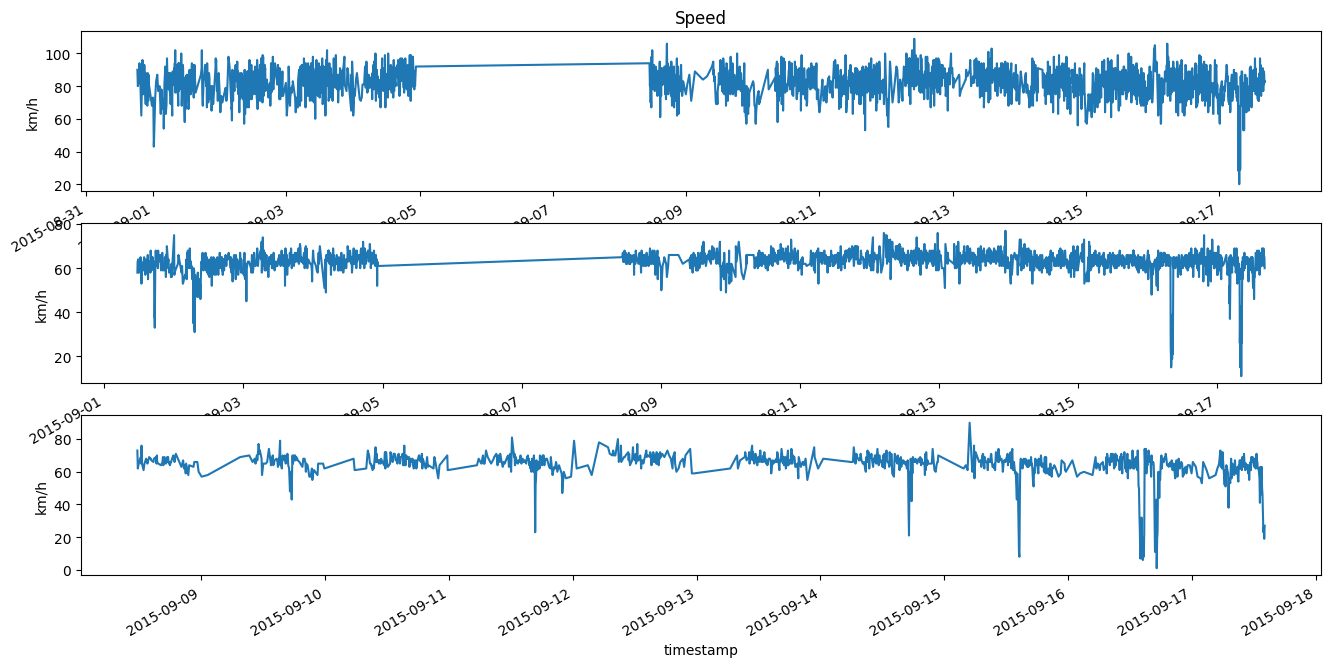

In [5]:
# Load speed dataset
df_s1 = pd.read_csv('speed_6005.csv').rename(columns={'value':'Speed'})
df_s2 = pd.read_csv('speed_t4013.csv').rename(columns={'value':'Speed'})
df_s3 = pd.read_csv('speed_7578.csv').rename(columns={'value':'Speed'})

# Set index
df_s1['timestamp'] = pd.to_datetime(df_s1['timestamp'])   # to datetime
df_s2['timestamp'] = pd.to_datetime(df_s2['timestamp'])
df_s3['timestamp'] = pd.to_datetime(df_s3['timestamp'])
df_s1 = df_s1.set_index('timestamp')
df_s2 = df_s2.set_index('timestamp')
df_s3 = df_s3.set_index('timestamp')
print(df_s2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(3, 1, 1)
df_s1['Speed'].plot(ylabel='km/h',title='Speed')
plt.subplot(3, 1, 2)
df_s2['Speed'].plot(ylabel='km/h')
plt.subplot(3, 1, 3)
df_s3['Speed'].plot(ylabel='km/h')

## 1. Form Dataset and Preprocess

- notice preprocess choices made, such as resampling

#### Joining, Resampling and Normalizing

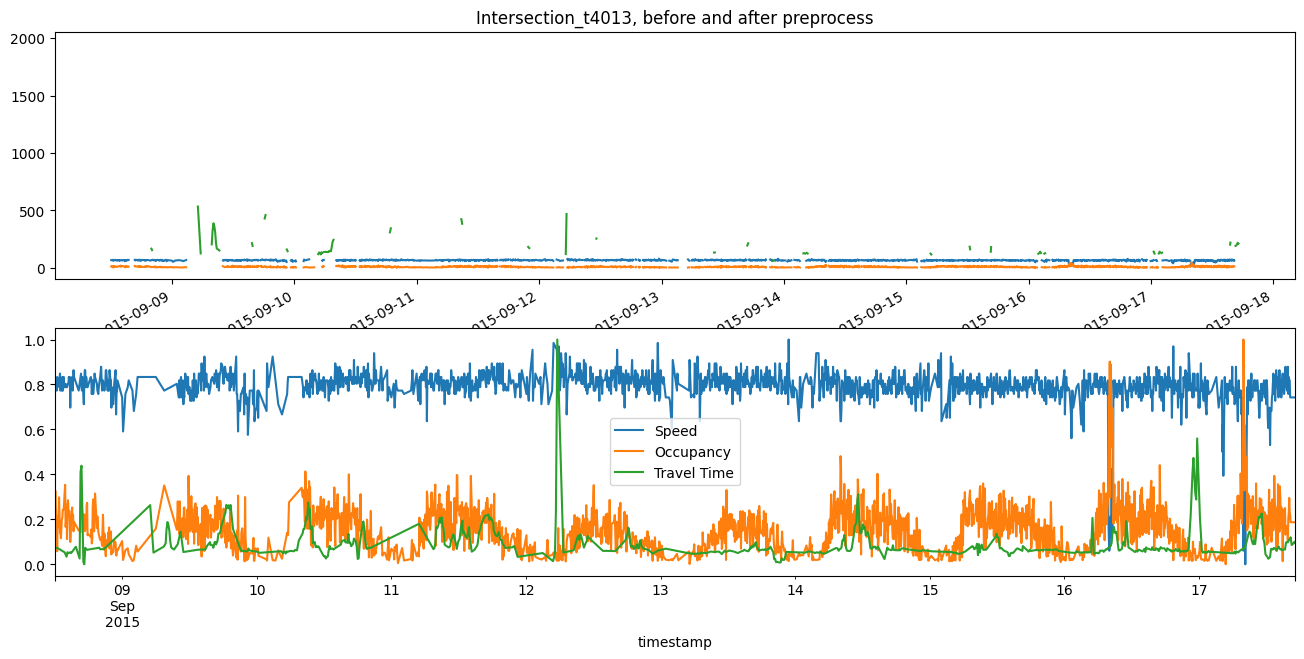

In [6]:
# Dataset for intersection 6005
# data_6005 = df_o1.join(df_t1, how='outer').join(df_s1, how='outer')
# data_6005 = data_6005['2015-09-09':]  # take only data after certain date             # if we wanted to do 2 intersections

# Dataset for intersection t4013
data_t4013 = df_o2.join(df_t2, how='outer').join(df_s2, how='outer')
data = data_t4013['2015-09-08 12':]  # take only data after certain date



# Plot data before resampling
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
data['Speed'].plot(title='Intersection_t4013, before and after preprocess')#, ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()


# Data after resampling (using mean) to 5 min intervals
# and handling missing data using _______(interpolation)________
data = data.resample('5min').mean()
data = data.interpolate()

data['Travel Time'] = data['Travel Time'].bfill()   # special case where Travel Time has few initial data points missing

# Normalize each variable using ________(MinMax)_________
scaler = MinMaxScaler()
data['Speed'] = scaler.fit_transform(data[['Speed']])
data['Occupancy'] = scaler.fit_transform(data[['Occupancy']])
data['Travel Time'] = scaler.fit_transform(data[['Travel Time']])


# Plot data after preprocessing
plt.subplot(2,1,2)
data['Speed'].plot()#ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()
plt.legend()
plt.show()


In [7]:
data.shape    # (2510 timesteps, 3 variables)

(2654, 3)

#### Components of the time series

In [8]:
# check seasonality, trends, etc for each variable

#### Splitting train and test sets

In [9]:
# Sliding window to split data

def sliding_window(data, n):
    # data: original data
    # n: window size
    X, y = [], []
    for i in range(len(data) - n):
        X.append(data[i:(i + n)])
        y.append(data[i + n])
    return np.array(X), np.array(y)


# For n timesteps
n_steps = 12      # each 60 minutes (5 minutes per timestep)

# Each variable
Xo, yo = sliding_window(data['Occupancy'], n_steps)
Xs, ys = sliding_window(data['Speed'], n_steps)
Xt, yt = sliding_window(data['Travel Time'], n_steps)

# Split data into training testing sets
split = int(len(Xo)*0.8)

Xo_train, Xo_test = Xo[:split], Xo[split:]
yo_train, yo_test = yo[:split], yo[split:]

Xs_train, Xs_test = Xs[:split], Xs[split:]
ys_train, ys_test = ys[:split], ys[split:]

Xt_train, Xt_test = Xt[:split], Xt[split:]
yt_train, yt_test = yt[:split], yt[split:]

# Reshape
Xo_train = Xo_train.reshape(Xo_train.shape[0], Xo_train.shape[1], 1)
Xo_test = Xo_test.reshape(Xo_test.shape[0], Xo_test.shape[1], 1)

Xs_train = Xs_train.reshape(Xs_train.shape[0], Xs_train.shape[1], 1)
Xs_test = Xs_test.reshape(Xs_test.shape[0], Xs_test.shape[1], 1)

Xt_train = Xt_train.reshape(Xt_train.shape[0], Xt_train.shape[1], 1)
Xt_test = Xt_test.reshape(Xt_test.shape[0], Xt_test.shape[1], 1)


/tmp/ipykernel_913/4273797092.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + n])


## 2. Models, Training

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Normalization
from keras.layers import LSTM, SimpleRNN, Conv1D, GRU
from tensorflow.keras.utils import plot_model

from sklearn.metrics import mean_squared_error, mean_absolute_error

from time import time

### CNN Model

In [11]:
# CNN model
model_CNN = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(Xo_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Optimizer ________ and loss _________
model_CNN.compile(optimizer='adam', loss='mean_squared_error')    # why?

model_CNN_s, model_CNN_o, model_CNN_t = model_CNN, model_CNN, model_CNN

# Choose parameters for training
EPOCHS = 50
BATCH_SIZE = 32
VAL_SPLIT = 0.2



2024-11-21 15:01:25.228262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 15:01:25.350221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 15:01:25.350300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 15:01:25.351161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

#### Training using CNN models

Epoch 1/50


2024-11-21 15:01:26.555013: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2024-11-21 15:01:26.702319: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/53 [..............................] - ETA: 40s - loss: 0.7305

2024-11-21 15:01:26.875343: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


53/53 [==============================] - 1s 7ms/step - loss: 0.0995 - val_loss: 0.0025
Epoch 2/50
53/53 [==============================] - 0s 4ms/step - loss: 0.0270 - val_loss: 0.0023
Epoch 3/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0218 - val_loss: 0.0021
Epoch 4/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0212 - val_loss: 0.0034
Epoch 5/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0203 - val_loss: 0.0026
Epoch 6/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0210 - val_loss: 0.0021
Epoch 7/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0019
Epoch 8/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0188 - val_loss: 0.0043
Epoch 9/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.0019
Epoch 10/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0187 - val_loss: 0.0018
Epoch 11/50
53/53 [===========

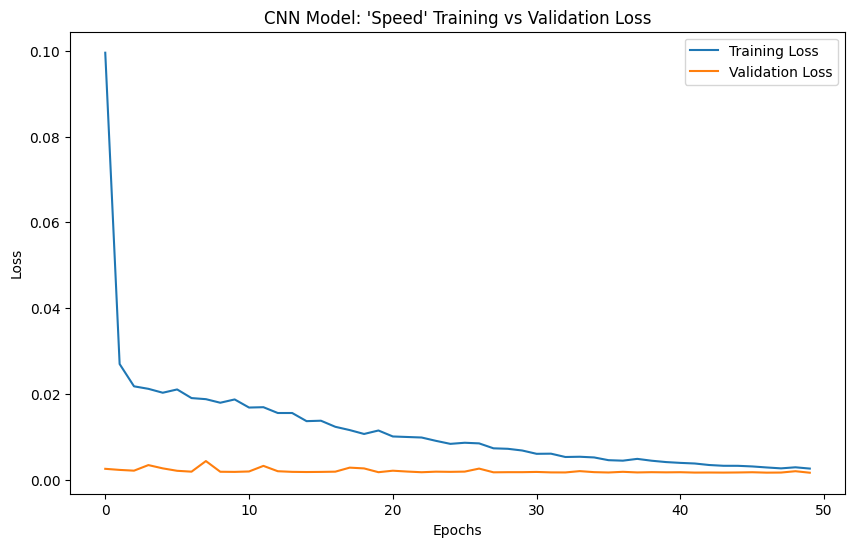

CNN Training Time for 'Speed': 15.484 seconds


In [12]:
# Speed data
start_time = time()
cnn_history_speed = model_CNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_speed.history['loss'], label='Training Loss')
plt.plot(cnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Speed\': {cnn_time_speed:.3f} seconds")


Epoch 1/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0445 - val_loss: 0.0049
Epoch 2/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0038
Epoch 3/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0038
Epoch 4/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0042
Epoch 5/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0040
Epoch 6/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 7/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0041
Epoch 8/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 9/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 10/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 11/50
53/53 [

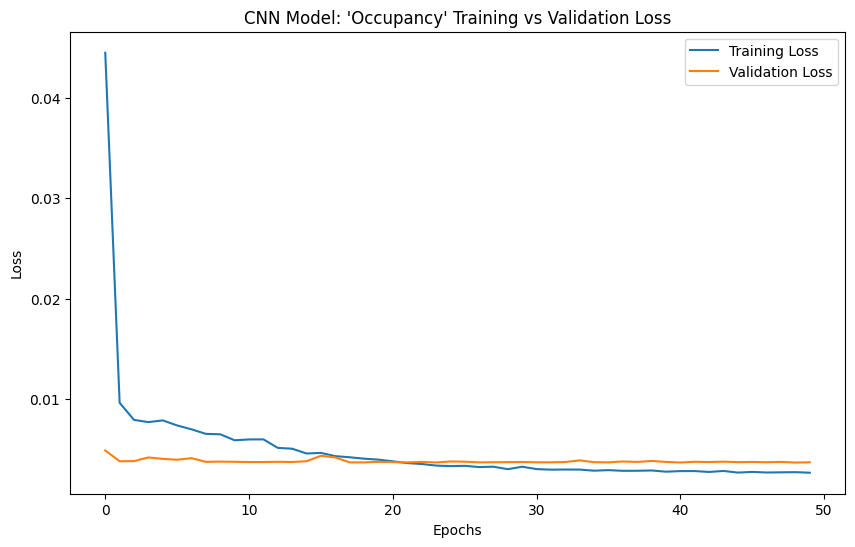

CNN Training Time for 'Occupancy': 14.062 seconds


In [13]:
# Occupancy data
start_time = time()
cnn_history_occupancy = model_CNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(cnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Occupancy\': {cnn_time_occupancy:.3f} seconds")

Epoch 1/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 2.2649e-04
Epoch 2/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 1.0716e-04
Epoch 3/50
53/53 [==============================] - 0s 5ms/step - loss: 8.8687e-04 - val_loss: 1.2494e-04
Epoch 4/50
53/53 [==============================] - 0s 8ms/step - loss: 8.5888e-04 - val_loss: 1.4142e-04
Epoch 5/50
53/53 [==============================] - 0s 5ms/step - loss: 6.9789e-04 - val_loss: 8.4829e-05
Epoch 6/50
53/53 [==============================] - 0s 5ms/step - loss: 7.2448e-04 - val_loss: 1.1293e-04
Epoch 7/50
53/53 [==============================] - 0s 5ms/step - loss: 6.1055e-04 - val_loss: 7.7170e-05
Epoch 8/50
53/53 [==============================] - 0s 5ms/step - loss: 5.6327e-04 - val_loss: 7.5226e-05
Epoch 9/50
53/53 [==============================] - 0s 5ms/step - loss: 4.8942e-04 - val_loss: 1.2091e-04
Epoch 10/50
53/53 [==============================] - 0

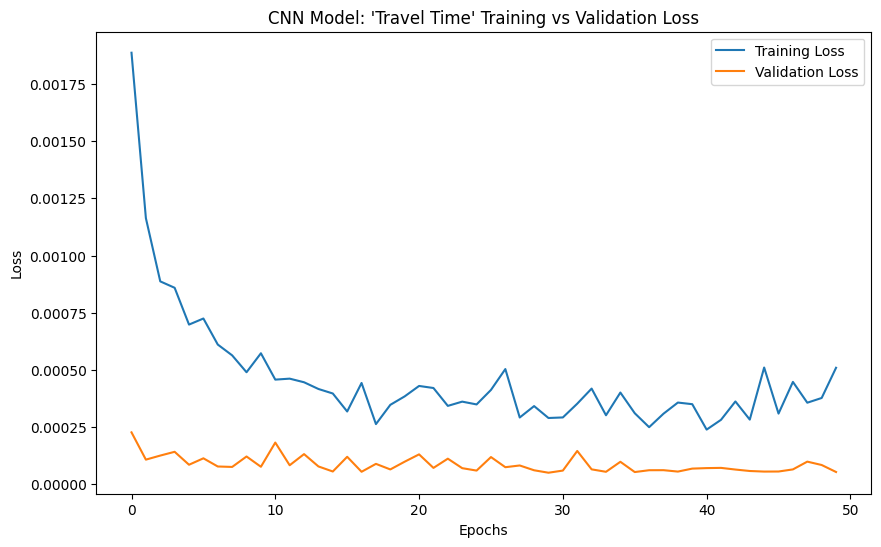

CNN Training Time for 'Travel Time': 13.447 seconds


In [14]:
# Travel Time data
start_time = time()
cnn_history_ttime = model_CNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(cnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Travel Time\': {cnn_time_ttime:.3f} seconds")


Epoch 1/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0027
Epoch 2/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.0018
Epoch 3/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0017
Epoch 4/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0016
Epoch 5/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0018
Epoch 6/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 7/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 8/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 9/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 10/50
53/53 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 11/50
53/53 [

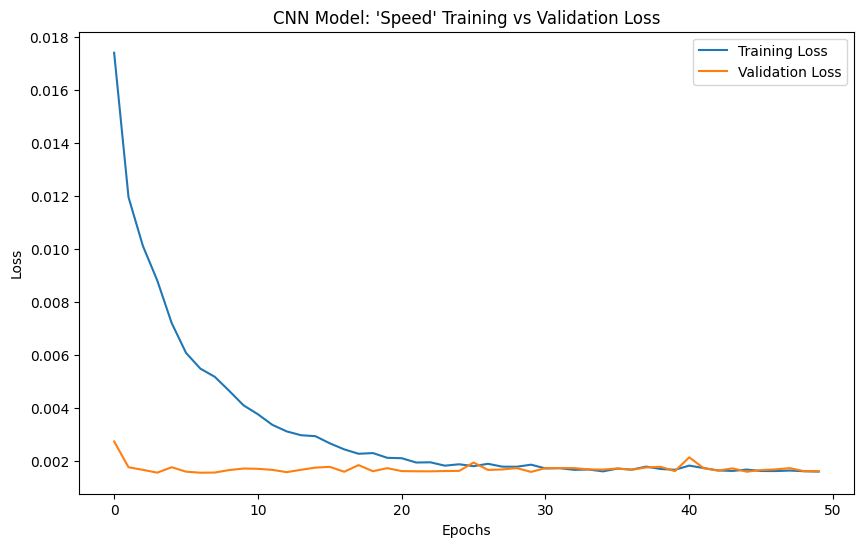

CNN Training Time for 'Speed': 13.276 seconds


In [15]:
# Speed data
start_time = time()
cnn_history_speed = model_CNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_speed.history['loss'], label='Training Loss')
plt.plot(cnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Speed\': {cnn_time_speed:.3f} seconds")

17/17 [==============================] - 0s 2ms/step
CNN Test: 'Speed' RMSE: 0.10843902522855134
CNN Test: 'Speed' MAE: 0.054473932317123094


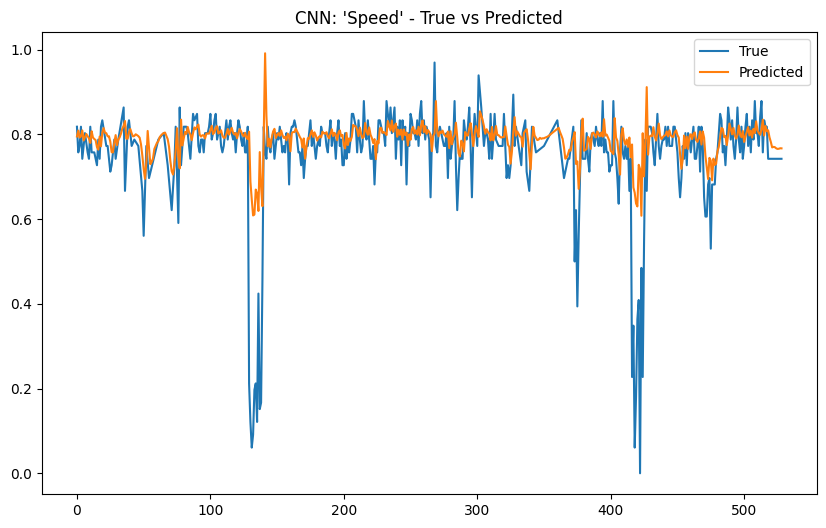

In [16]:
# Evaluate and plot predictions
ys_pred_cnn = model_CNN_s.predict(Xs_test)
# Calculate RMSE and MAE
cnn_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_cnn))
cnn_mae_s = mean_absolute_error(ys_test, ys_pred_cnn)           # why mse and rmse?

print(f'CNN Test: \'Speed\' RMSE: {cnn_rmse_s}')
print(f'CNN Test: \'Speed\' MAE: {cnn_mae_s}')

plt.figure(figsize=(10,6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_cnn, label='Predicted')
plt.title('CNN: \'Speed\' - True vs Predicted')
plt.legend()
plt.show()

17/17 [==============================] - 0s 2ms/step
CNN Test: 'Occupancy' RMSE: 0.49703160729750434
CNN Test: 'Occupancy' MAE: 0.48724524147446974


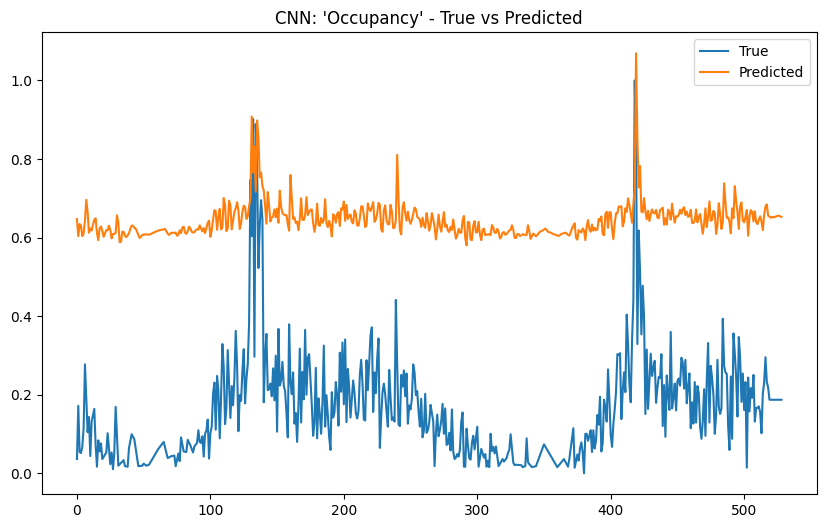

In [17]:
# Evaluate and plot predictions
yo_pred_cnn = model_CNN_o.predict(Xo_test)
# Calculate RMSE and MAE
cnn_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_cnn))
cnn_mae_o = mean_absolute_error(yo_test, yo_pred_cnn)

print(f'CNN Test: \'Occupancy\' RMSE: {cnn_rmse_o}')
print(f'CNN Test: \'Occupancy\' MAE: {cnn_mae_o}')

plt.figure(figsize=(10,6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_cnn, label='Predicted')
plt.title('CNN: \'Occupancy\' - True vs Predicted')
plt.legend()
plt.show()

17/17 [==============================] - 0s 2ms/step
CNN Test: 'Travel Time' RMSE: 0.5401911733225788
CNN Test: 'Travel Time' MAE: 0.5376256882980566


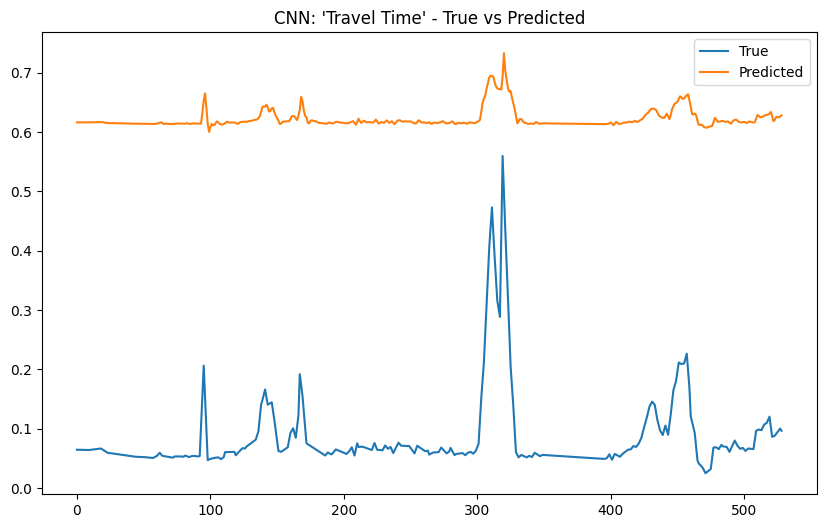

In [18]:
# Evaluate and plot predictions
yt_pred_cnn = model_CNN_t.predict(Xt_test)
# Calculate RMSE and MAE
cnn_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_cnn))
cnn_mae_t = mean_absolute_error(yt_test, yt_pred_cnn)

print(f'CNN Test: \'Travel Time\' RMSE: {cnn_rmse_t}')
print(f'CNN Test: \'Travel Time\' MAE: {cnn_mae_t}')

plt.figure(figsize=(10,6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_cnn, label='Predicted')
plt.title('CNN: \'Travel Time\' - True vs Predicted')
plt.legend()
plt.show()

## RNN Models


In [19]:
# RNN model
model_RNN = Sequential([
    SimpleRNN(40, activation='relu', input_shape=(Xo_train.shape[1], 1)),   # why layer size 40?
    Dense(1)
])

# Optimizer ________ and loss _________
model_RNN.compile(optimizer='adam', loss='mean_squared_error')    # why?

model_RNN_s, model_RNN_o, model_RNN_t = model_RNN, model_RNN, model_RNN

# Choose parameters for training
EPOCHS = 50
BATCH_SIZE = 16
VAL_SPLIT = 0.2


#### Training using RNN models

Epoch 1/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0360 - val_loss: 0.0016
Epoch 2/50
106/106 [==============================] - 2s 16ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/50
106/106 [==============================] - 2s 14ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
106/106 [==============================] - 2s 16ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0016 - val_lo

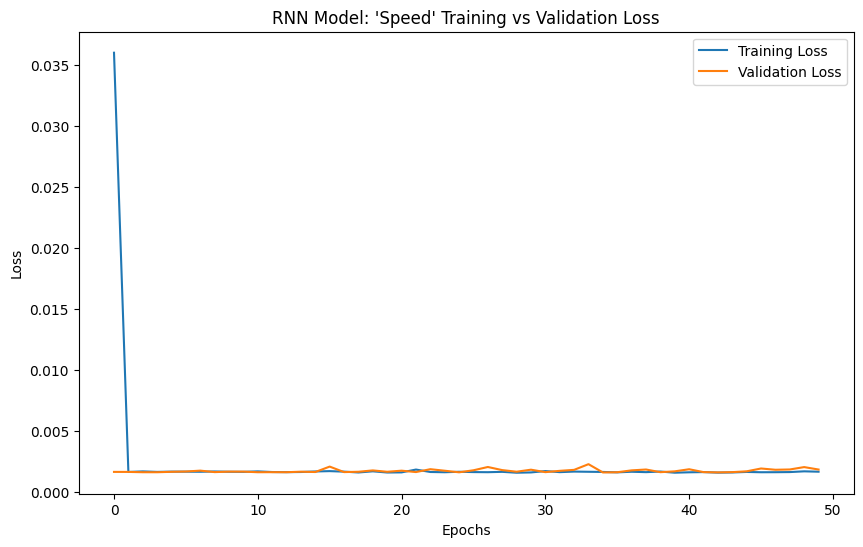

RNN Training Time for 'Speed': 79.273 seconds


In [20]:
# Speed data
start_time = time()
rnn_history_speed = model_RNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(rnn_history_speed.history['loss'], label='Training Loss')
plt.plot(rnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Speed\': {rnn_time_speed:.3f} seconds")


Epoch 1/50
106/106 [==============================] - 2s 16ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 2/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 3/50
106/106 [==============================] - 2s 16ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 4/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 5/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 6/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 7/50
106/106 [==============================] - 2s 15ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 8/50
106/106 [==============================] - 2s 14ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 9/50
106/106 [==============================] - 2s 14ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 10/50
106/106 [==============================] - 1s 14ms/step - loss: 0.0025 - val_lo

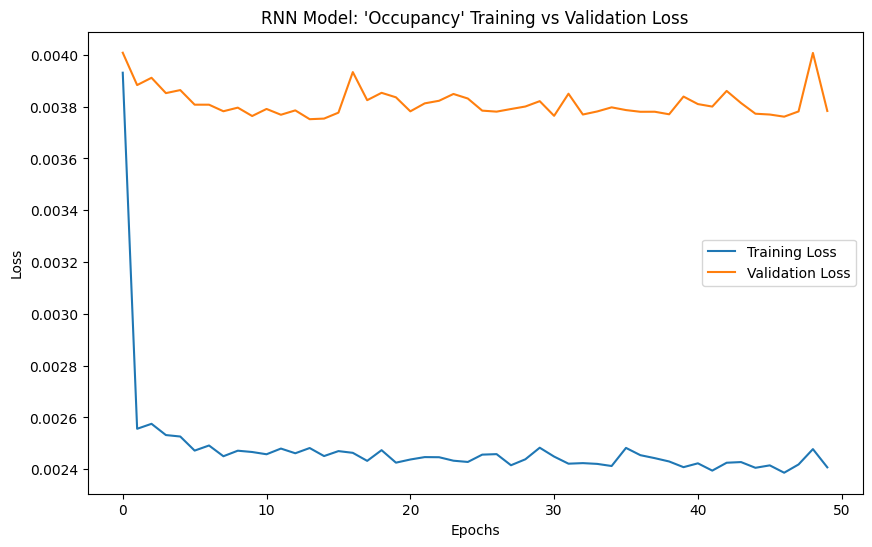

RNN Training Time for 'Occupancy': 79.598 seconds


In [21]:
# Occupancy data
start_time = time()
rnn_history_occupancy = model_RNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(rnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(rnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Occupancy\': {rnn_time_occupancy:.3f} seconds")

Epoch 1/50
106/106 [==============================] - 2s 16ms/step - loss: 7.9372e-04 - val_loss: 7.2875e-05
Epoch 2/50
106/106 [==============================] - 2s 16ms/step - loss: 3.0279e-04 - val_loss: 6.0747e-05
Epoch 3/50
106/106 [==============================] - 2s 15ms/step - loss: 2.2674e-04 - val_loss: 5.0753e-05
Epoch 4/50
106/106 [==============================] - 2s 15ms/step - loss: 1.8948e-04 - val_loss: 5.1923e-05
Epoch 5/50
106/106 [==============================] - 2s 16ms/step - loss: 1.8588e-04 - val_loss: 7.0964e-05
Epoch 6/50
106/106 [==============================] - 2s 15ms/step - loss: 1.7359e-04 - val_loss: 6.0761e-05
Epoch 7/50
106/106 [==============================] - 2s 15ms/step - loss: 1.7730e-04 - val_loss: 7.8733e-05
Epoch 8/50
106/106 [==============================] - 2s 15ms/step - loss: 1.6753e-04 - val_loss: 4.4881e-05
Epoch 9/50
106/106 [==============================] - 2s 15ms/step - loss: 1.5455e-04 - val_loss: 5.1522e-05
Epoch 10/50
106/106

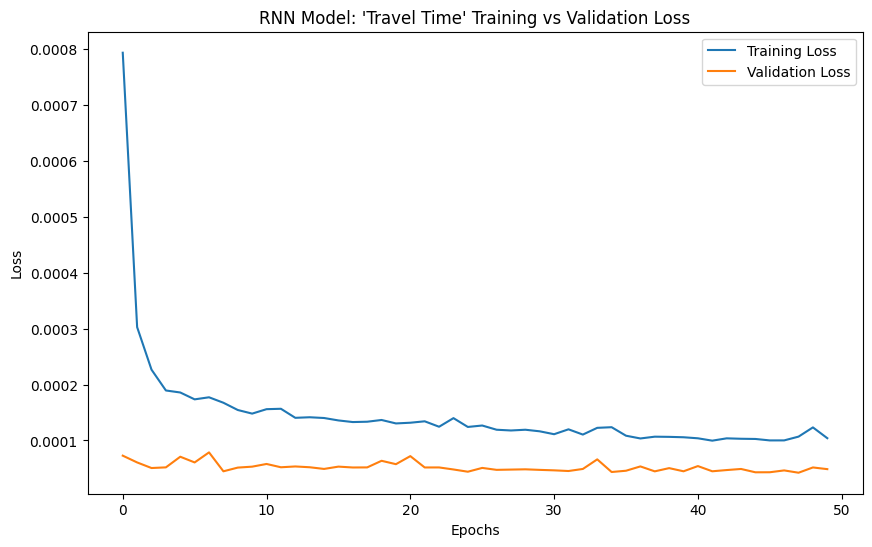

RNN Training Time for 'Travel Time': 80.510 seconds


In [22]:
# Travel Time data
start_time = time()
rnn_history_ttime = model_RNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(rnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(rnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Travel Time\': {rnn_time_ttime:.3f} seconds")


### Evaluating using RNN Models

17/17 [==============================] - 0s 4ms/step
RNN Test: 'Speed' RMSE: 0.1203204203651231
RNN Test: 'Speed' MAE: 0.07650142095529058


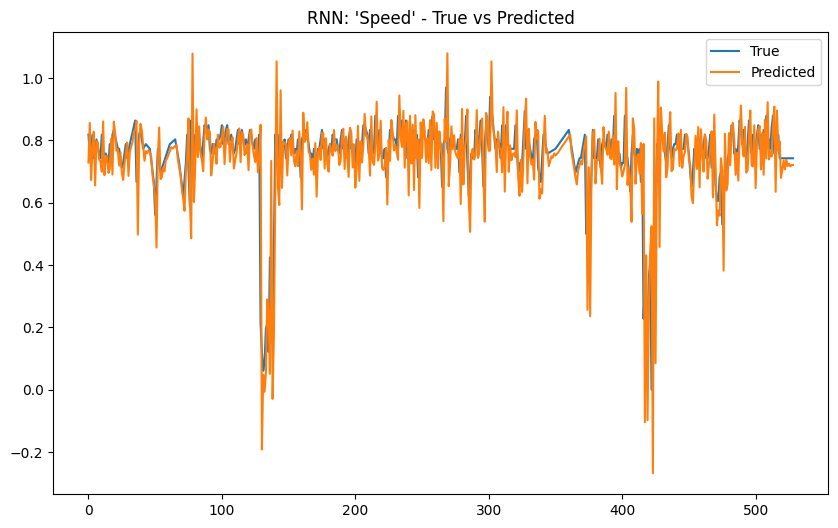

In [23]:
# Evaluate and plot predictions
ys_pred_rnn = model_RNN_s.predict(Xs_test)
# Calculate RMSE and MAE
rnn_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_rnn))
rnn_mae_s = mean_absolute_error(ys_test, ys_pred_rnn)           # why mse and rmse?

print(f'RNN Test: \'Speed\' RMSE: {rnn_rmse_s}')
print(f'RNN Test: \'Speed\' MAE: {rnn_mae_s}')

plt.figure(figsize=(10,6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_rnn, label='Predicted')
plt.title('RNN: \'Speed\' - True vs Predicted')
plt.legend()
plt.show()

17/17 [==============================] - 0s 4ms/step
RNN Test: 'Occupancy' RMSE: 0.14947720897596783
RNN Test: 'Occupancy' MAE: 0.09706285995817009


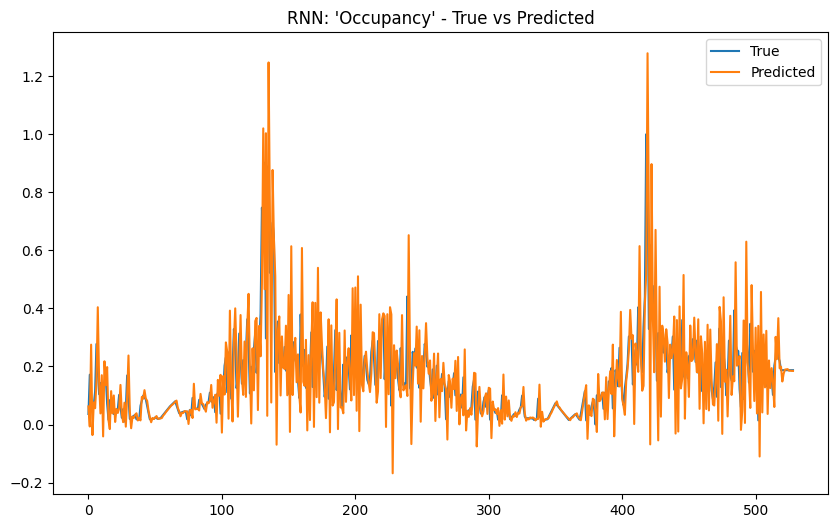

In [24]:
# Evaluate and plot predictions
yo_pred_rnn = model_RNN_o.predict(Xo_test)
# Calculate RMSE and MAE
rnn_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_rnn))
rnn_mae_o = mean_absolute_error(yo_test, yo_pred_rnn)

print(f'RNN Test: \'Occupancy\' RMSE: {rnn_rmse_o}')
print(f'RNN Test: \'Occupancy\' MAE: {rnn_mae_o}')

plt.figure(figsize=(10,6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_rnn, label='Predicted')
plt.title('RNN: \'Occupancy\' - True vs Predicted')
plt.legend()
plt.show()

17/17 [==============================] - 0s 4ms/step
RNN Test: 'Travel Time' RMSE: 0.01424123889014609
RNN Test: 'Travel Time' MAE: 0.004856636718962871


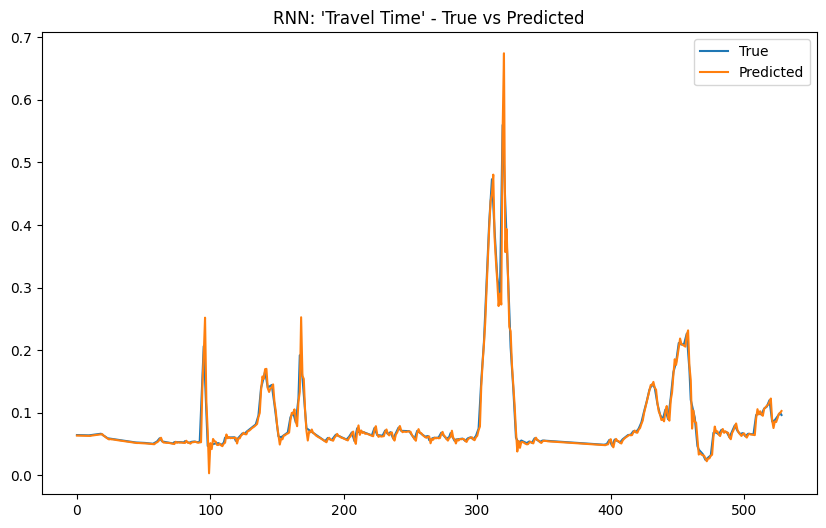

In [25]:
# Evaluate and plot predictions
yt_pred_rnn = model_RNN_t.predict(Xt_test)
# Calculate RMSE and MAE
rnn_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_rnn))
rnn_mae_t = mean_absolute_error(yt_test, yt_pred_rnn)

print(f'RNN Test: \'Travel Time\' RMSE: {rnn_rmse_t}')
print(f'RNN Test: \'Travel Time\' MAE: {rnn_mae_t}')

plt.figure(figsize=(10,6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_rnn, label='Predicted')
plt.title('RNN: \'Travel Time\' - True vs Predicted')
plt.legend()
plt.show()

## LTSM Model

### Trainning LTSM models

Epoch 1/50
53/53 [==============================] - 5s 76ms/step - loss: 0.0945 - val_loss: 0.0028
Epoch 2/50
53/53 [==============================] - 4s 72ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 6/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 7/50
53/53 [==============================] - 4s 74ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 8/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/50
53/53 [==============================] - 4s 76ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 10/50
53/53 [==============================] - 4s 72ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 11/

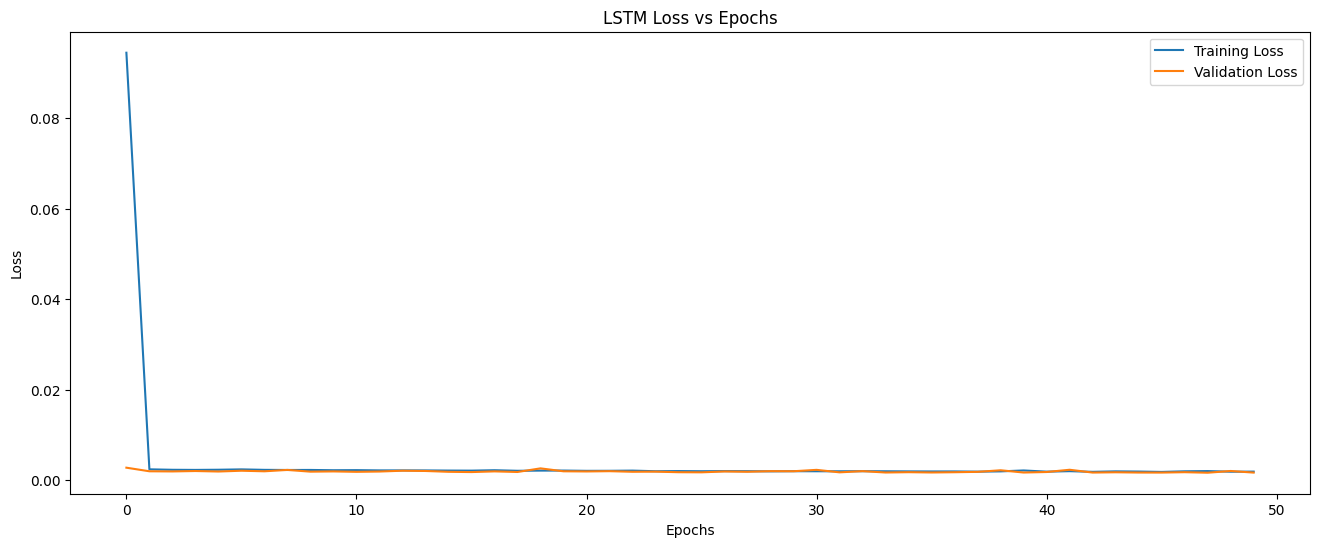

LSTM Training Time for 'Speed': 193.738 seconds


In [30]:
#Speed Data
#LSTM model with 2 LSTM layers of size 100 and 50, RELU, 100 epochs, batch size 16, adam.
modelLSTM_s = Sequential()
modelLSTM_s.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(Xs_train.shape[1], 1)))
modelLSTM_s.add(LSTM(50, activation='relu'))
modelLSTM_s.add(Dense(1))
modelLSTM_s.compile(optimizer='adam', loss='mse')
start_time = time()
LSTM_history_speed = modelLSTM_s.fit(Xs_train, ys_train, epochs=50, batch_size=32, validation_split=0.2)
LSTM_time_speed = time() - start_time

#plot the training and validation loss
plt.figure(figsize=(16, 6))
plt.plot(LSTM_history_speed.history['loss'], label='Training Loss')
plt.plot(LSTM_history_speed.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(f"LSTM Training Time for \'Speed\': {LSTM_time_speed:.3f} seconds")

Epoch 1/25
53/53 [==============================] - 5s 74ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 2/25
53/53 [==============================] - 4s 72ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 3/25
53/53 [==============================] - 4s 69ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 4/25
53/53 [==============================] - 4s 70ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 5/25
53/53 [==============================] - 4s 68ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 6/25
53/53 [==============================] - 4s 67ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 7/25
53/53 [==============================] - 4s 73ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 8/25
53/53 [==============================] - 4s 71ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 9/25
53/53 [==============================] - 4s 68ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 10/25
53/53 [==============================] - 4s 72ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 11/

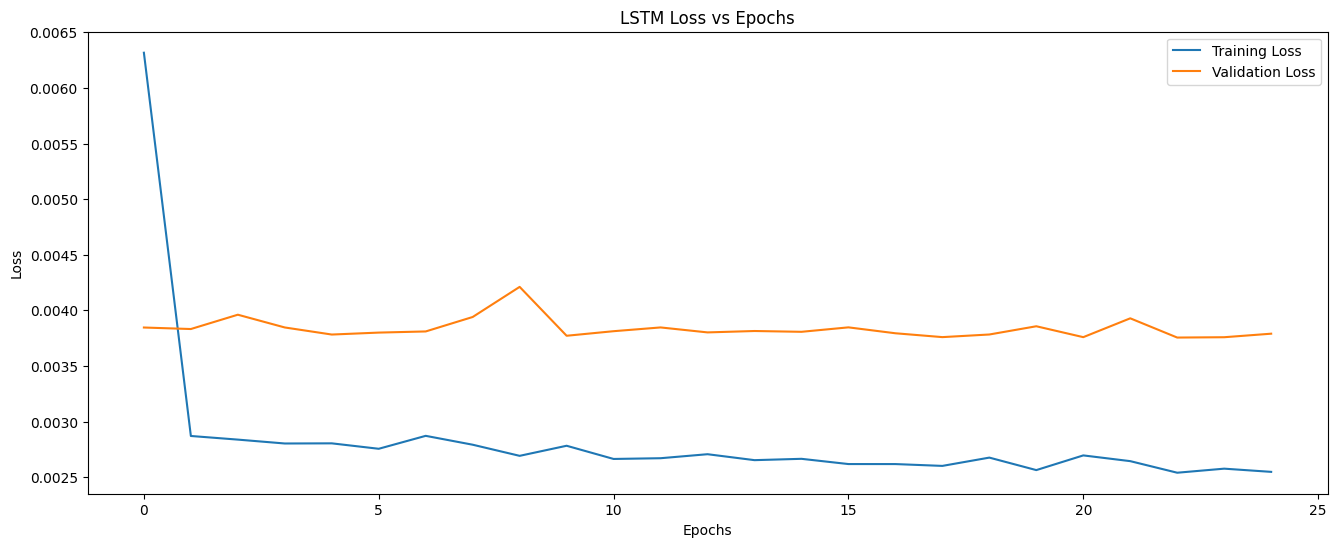

LSTM Training Time for 'Occupancy': 92.542 seconds


In [32]:
#Occupancy Data
#LSTM model with 2 LSTM layers of size 100 and 50, RELU, 100 epochs, batch size 16, adam.
modelLSTM_o = Sequential()
modelLSTM_o.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(Xo_train.shape[1], 1)))
modelLSTM_o.add(LSTM(50, activation='relu'))
modelLSTM_o.add(Dense(1))
modelLSTM_o.compile(optimizer='adam', loss='mse')
start_time = time()
LSTM_history_occupancy = modelLSTM_o.fit(Xo_train, yo_train, epochs=25, batch_size=32, validation_split=0.2)
LSTM_time_occupancy = time() - start_time

#plot the training and validation loss
plt.figure(figsize=(16, 6))
plt.plot(LSTM_history_occupancy.history['loss'], label='Training Loss')
plt.plot(LSTM_history_occupancy.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(f"LSTM Training Time for \'Occupancy\': {LSTM_time_occupancy:.3f} seconds")

Epoch 1/25
53/53 [==============================] - 5s 78ms/step - loss: 0.0044 - val_loss: 5.0289e-04
Epoch 2/25
53/53 [==============================] - 4s 73ms/step - loss: 0.0029 - val_loss: 4.9888e-04
Epoch 3/25
53/53 [==============================] - 4s 71ms/step - loss: 0.0023 - val_loss: 3.3966e-04
Epoch 4/25
53/53 [==============================] - 4s 70ms/step - loss: 0.0017 - val_loss: 2.9320e-04
Epoch 5/25
53/53 [==============================] - 6s 120ms/step - loss: 0.0015 - val_loss: 3.5257e-04
Epoch 6/25
53/53 [==============================] - 4s 76ms/step - loss: 0.0014 - val_loss: 2.7682e-04
Epoch 7/25
53/53 [==============================] - 4s 73ms/step - loss: 0.0013 - val_loss: 3.1186e-04
Epoch 8/25
53/53 [==============================] - 4s 70ms/step - loss: 0.0011 - val_loss: 3.8739e-04
Epoch 9/25
53/53 [==============================] - 4s 73ms/step - loss: 9.8247e-04 - val_loss: 2.7844e-04
Epoch 10/25
53/53 [==============================] - 4s 71ms/step - 

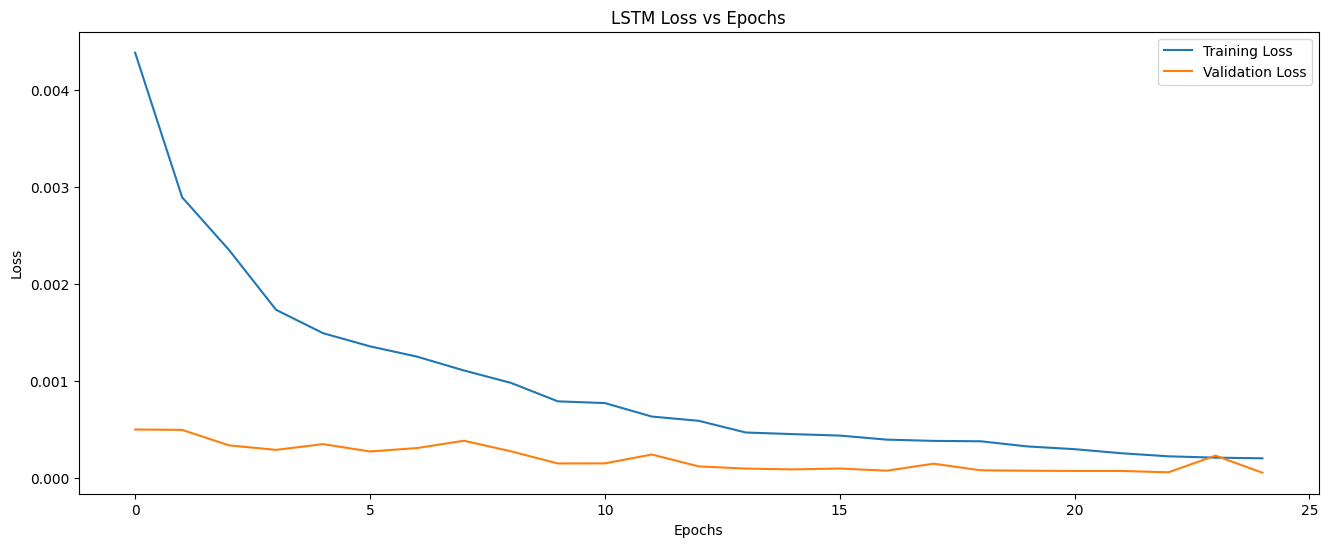

LSTM Training Time for 'travel time': 98.376 seconds


In [34]:
#Travel time Data
#LSTM model with 2 LSTM layers of size 100 and 50, RELU, 100 epochs, batch size 16, adam.
modelLSTM_ttime = Sequential()
modelLSTM_ttime.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(Xt_train.shape[1], 1)))
modelLSTM_ttime.add(LSTM(50, activation='relu'))
modelLSTM_ttime.add(Dense(1))
modelLSTM_ttime.compile(optimizer='adam', loss='mse')
start_time = time()
LSTM_history_ttime = modelLSTM_ttime.fit(Xt_train, yt_train, epochs=25, batch_size=32, validation_split=0.2)
LSTM_time_ttime = time() - start_time

#plot the training and validation loss
plt.figure(figsize=(16, 6))
plt.plot(LSTM_history_ttime.history['loss'], label='Training Loss')
plt.plot(LSTM_history_ttime.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(f"LSTM Training Time for \'travel time\': {LSTM_time_ttime:.3f} seconds")

#### Evaluating and plotting predictions

17/17 [==============================] - 1s 31ms/step
RMSE: 0.0968014069704321
MAE: 0.053398647931963


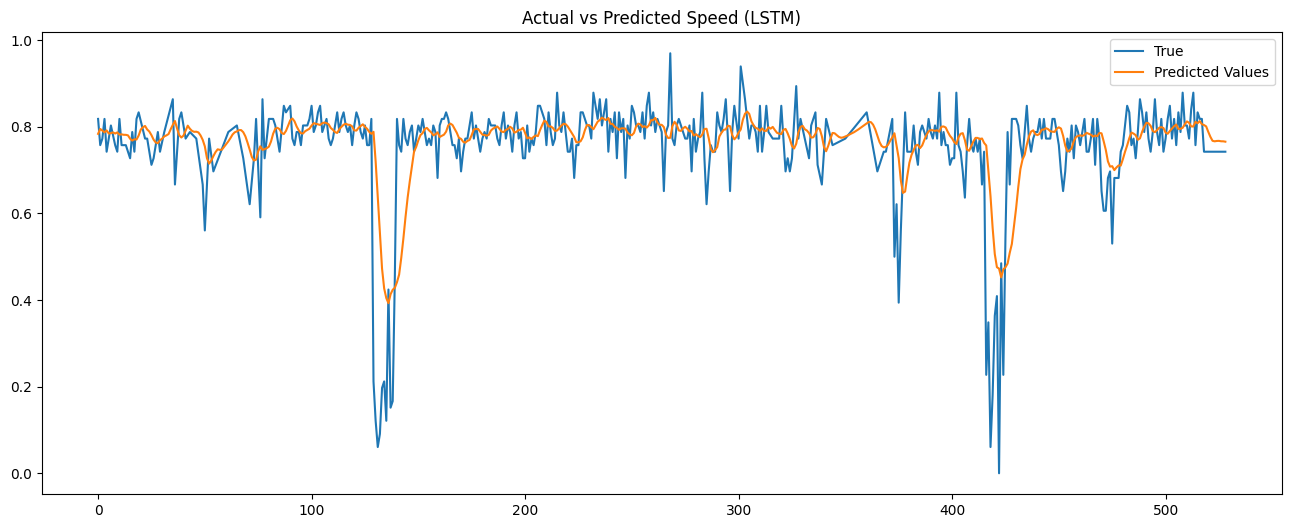

In [35]:
#Speed
#Analyze the model's performance with RMSE and MAE using the test data
ys_pred_LSTM = modelLSTM_s.predict(Xs_test)
LSTM_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_LSTM)) 
LSTM_mae_s = mean_absolute_error(ys_test, ys_pred_LSTM)
print('RMSE:', LSTM_rmse_s)
print('MAE:', LSTM_mae_s)

#visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16, 6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_LSTM.flatten(), label='Predicted Values')
plt.title('Actual vs Predicted Speed (LSTM)')
plt.legend()
plt.show()

17/17 [==============================] - 0s 21ms/step
RMSE: 0.08840858657661003
MAE: 0.05428365620969006


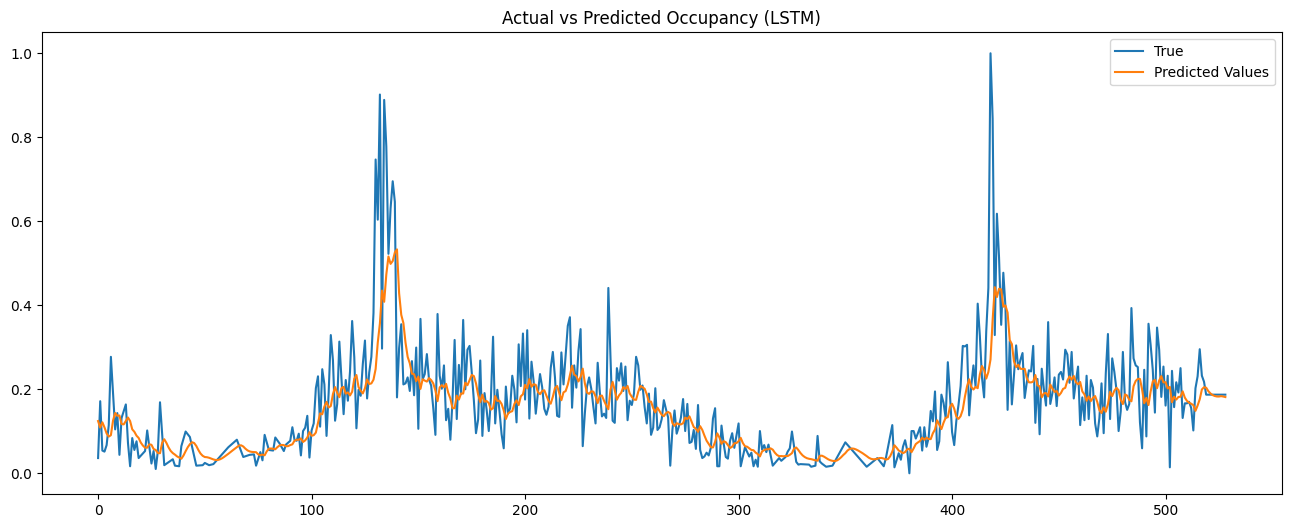

In [36]:
#Occupancy
#Analyze the model's performance with RMSE and MAE using the test data
yo_pred_LSTM = modelLSTM_o.predict(Xo_test)
LSTM_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_LSTM)) 
LSTM_mae_o = mean_absolute_error(yo_test, yo_pred_LSTM)
print('RMSE:', LSTM_rmse_o)
print('MAE:', LSTM_mae_o)

#visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16, 6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_LSTM.flatten(), label='Predicted Values')
plt.title('Actual vs Predicted Occupancy (LSTM)')
plt.legend()
plt.show()

17/17 [==============================] - 0s 20ms/step
RMSE: 0.014761901521283597
MAE: 0.0059525025095393804


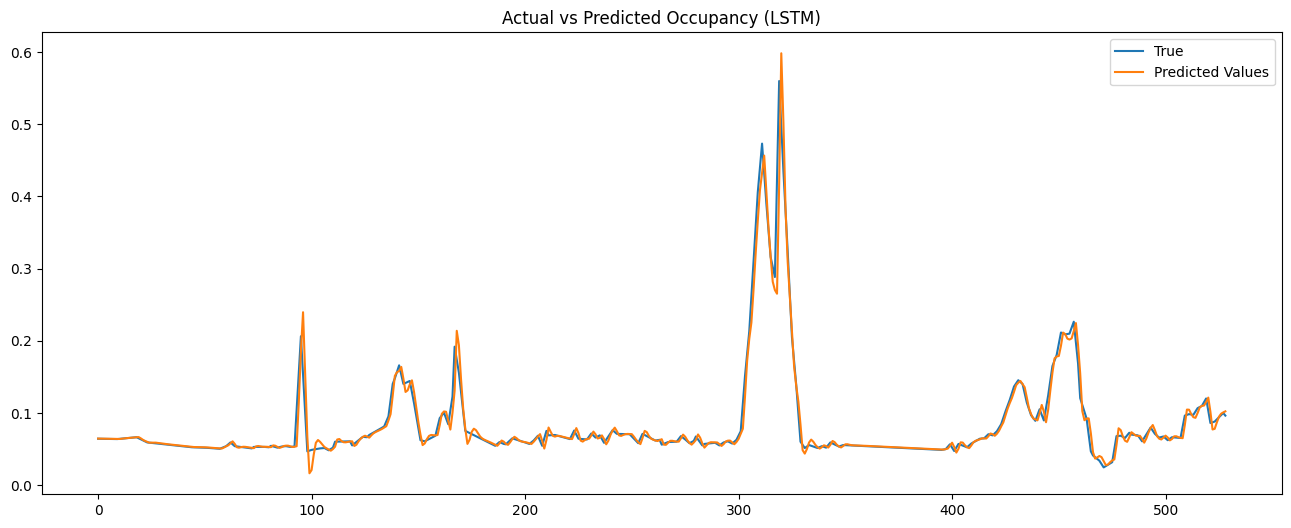

In [37]:
#Travel time
#Analyze the model's performance with RMSE and MAE using the test data
yt_pred_LSTM = modelLSTM_ttime.predict(Xt_test)
LSTM_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_LSTM)) 
LSTM_mae_t = mean_absolute_error(yt_test, yt_pred_LSTM)
print('RMSE:', LSTM_rmse_t)
print('MAE:', LSTM_mae_t)

#visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16, 6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_LSTM.flatten(), label='Predicted Values')
plt.title('Actual vs Predicted Occupancy (LSTM)')
plt.legend()
plt.show()

## GRUs modelling
#### Model trainning

In [38]:
import tensorflow as tf

Epoch 1/25
53/53 [==============================] - 6s 97ms/step - loss: 0.2446 - val_loss: 0.0018
Epoch 2/25
53/53 [==============================] - 5s 91ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 3/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/25
53/53 [==============================] - 5s 87ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/25
53/53 [==============================] - 5s 92ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/25
53/53 [==============================] - 5s 86ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/

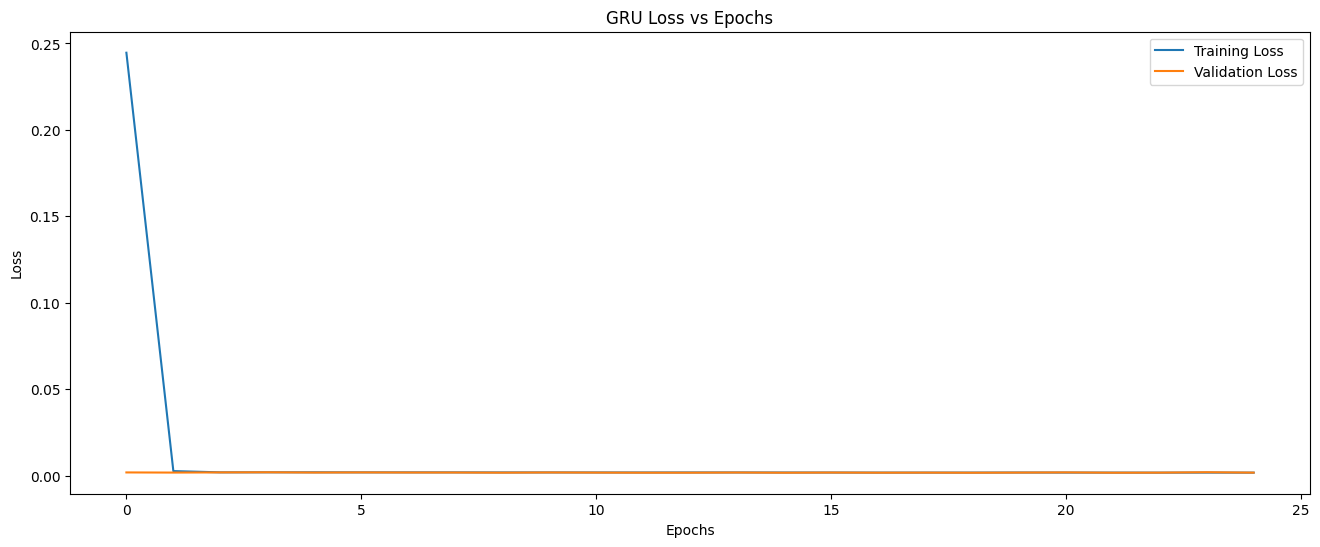

In [40]:
#Speed data
#GRU model with 2 GRU layers of size 80 and 40, Relu, 100 epochs, batch size 16, adam.
modelGRU_s = Sequential()
modelGRU_s.add(tf.keras.layers.GRU(80, activation='relu', return_sequences=True, input_shape=(Xs_train.shape[1], 1)))
modelGRU_s.add(tf.keras.layers.GRU(40, activation='relu'))
modelGRU_s.add(Dense(1))
modelGRU_s.compile(optimizer='adam', loss='mse')
start_time = time()
GRU_history_s = modelGRU_s.fit(Xs_train, ys_train, epochs=25, batch_size=32, validation_split=0.2)
GRU_time_speed = time() - start_time


#plot the training and validation loss
plt.figure(figsize=(16, 6))
plt.plot(GRU_history_s.history['loss'], label='Training Loss')
plt.plot(GRU_history_s.history['val_loss'], label='Validation Loss')
plt.title('GRU Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print(f"GRU Training Time for \'Speed\': {GRU_time_speed:.3f} seconds")

Epoch 1/25
53/53 [==============================] - 6s 94ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 2/25
53/53 [==============================] - 5s 90ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 3/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 4/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 5/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 6/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 7/25
53/53 [==============================] - 5s 91ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 8/25
53/53 [==============================] - 5s 88ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 9/25
53/53 [==============================] - 5s 88ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 10/25
53/53 [==============================] - 5s 90ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 11/

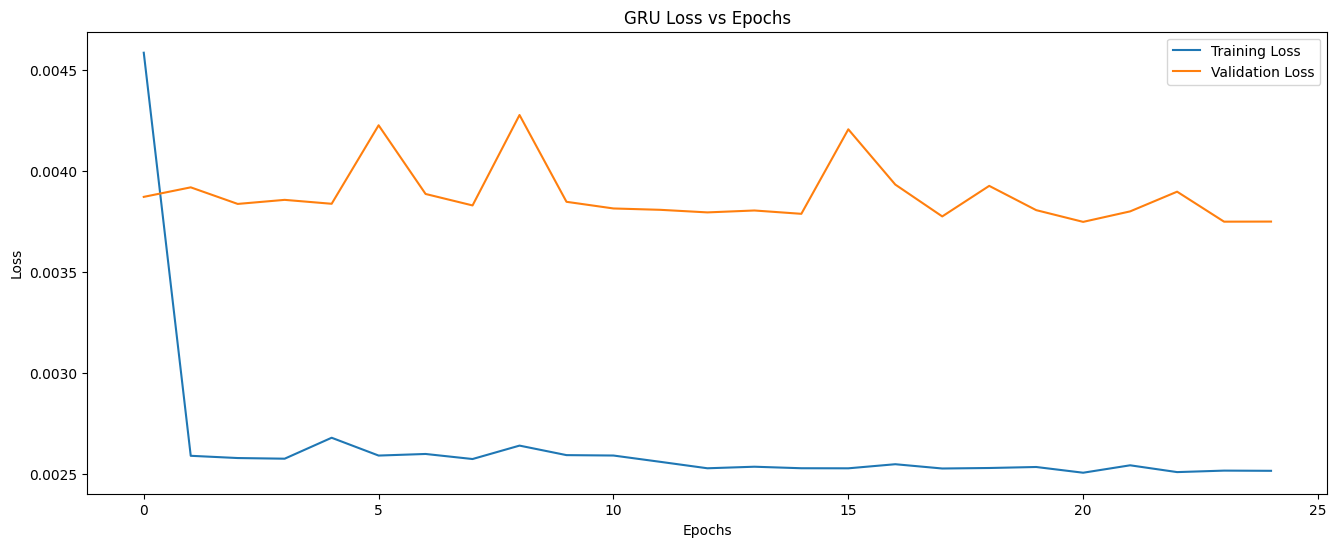

In [42]:
#Occupancy data
#GRU model with 2 GRU layers of size 80 and 40, Relu, 100 epochs, batch size 16, adam.
modelGRU_o = Sequential()
modelGRU_o.add(tf.keras.layers.GRU(80, activation='relu', return_sequences=True, input_shape=(Xo_train.shape[1], 1)))
modelGRU_o.add(tf.keras.layers.GRU(40, activation='relu'))
modelGRU_o.add(Dense(1))
modelGRU_o.compile(optimizer='adam', loss='mse')
start_time = time()
GRU_history_o = modelGRU_o.fit(Xo_train, yo_train, epochs=25, batch_size=32, validation_split=0.2)
GRU_time_o = time() - start_time


#plot the training and validation loss
plt.figure(figsize=(16, 6))
plt.plot(GRU_history_o.history['loss'], label='Training Loss')
plt.plot(GRU_history_o.history['val_loss'], label='Validation Loss')
plt.title('GRU Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print(f"GRU Training Time for \'Occupancy\': {GRU_time_o:.3f} seconds")

Epoch 1/25
53/53 [==============================] - 6s 94ms/step - loss: 0.0034 - val_loss: 6.6094e-04
Epoch 2/25
53/53 [==============================] - 5s 91ms/step - loss: 0.0015 - val_loss: 2.5075e-04
Epoch 3/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0010 - val_loss: 2.1465e-04
Epoch 4/25
53/53 [==============================] - 5s 92ms/step - loss: 7.5694e-04 - val_loss: 2.6356e-04
Epoch 5/25
53/53 [==============================] - 5s 90ms/step - loss: 6.4915e-04 - val_loss: 1.1162e-04
Epoch 6/25
53/53 [==============================] - 5s 93ms/step - loss: 5.2257e-04 - val_loss: 1.0666e-04
Epoch 7/25
53/53 [==============================] - 5s 90ms/step - loss: 4.3927e-04 - val_loss: 1.0347e-04
Epoch 8/25
53/53 [==============================] - 5s 88ms/step - loss: 4.1070e-04 - val_loss: 1.3253e-04
Epoch 9/25
53/53 [==============================] - 5s 90ms/step - loss: 3.3918e-04 - val_loss: 1.0942e-04
Epoch 10/25
53/53 [==============================

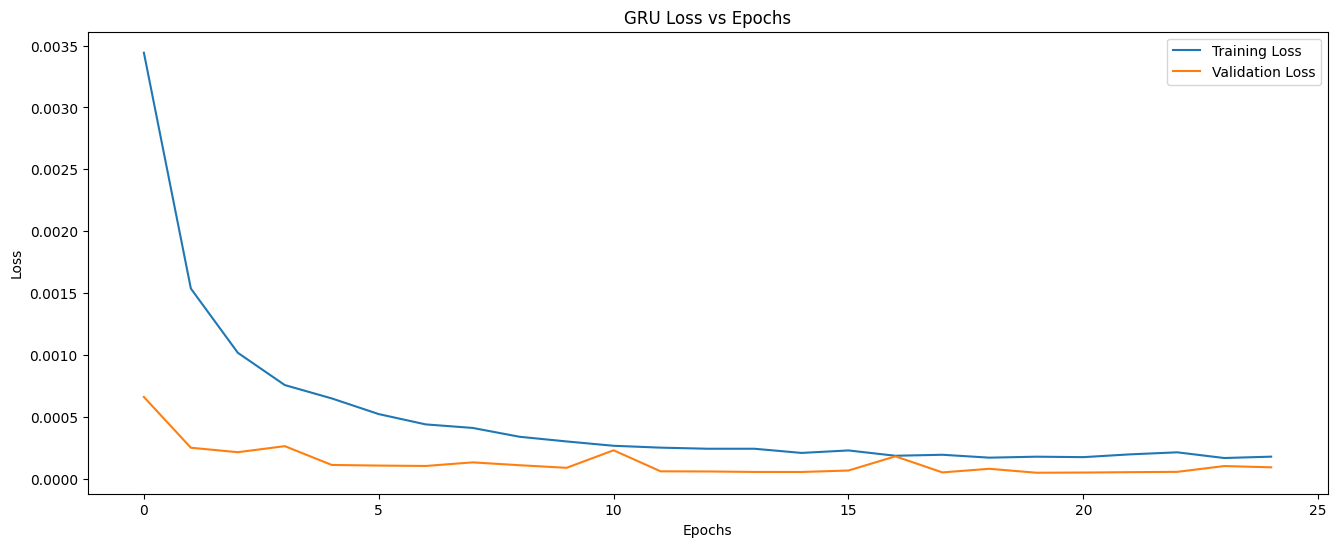

In [44]:
#Travel time data
#GRU model with 2 GRU layers of size 80 and 40, Relu, 100 epochs, batch size 16, adam.
modelGRU_tt = Sequential()
modelGRU_tt.add(tf.keras.layers.GRU(80, activation='relu', return_sequences=True, input_shape=(Xt_train.shape[1], 1)))
modelGRU_tt.add(tf.keras.layers.GRU(40, activation='relu'))
modelGRU_tt.add(Dense(1))
modelGRU_tt.compile(optimizer='adam', loss='mse')
start_time = time()
GRU_history_tt = modelGRU_tt.fit(Xt_train, yt_train, epochs=25, batch_size=32, validation_split=0.2)
GRU_time_tt = time() - start_time


#plot the training and validation loss
plt.figure(figsize=(16, 6))
plt.plot(GRU_history_tt.history['loss'], label='Training Loss')
plt.plot(GRU_history_tt.history['val_loss'], label='Validation Loss')
plt.title('GRU Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print(f"GRU Training Time for \'Travel Time\': {GRU_time_tt:.3f} seconds")

17/17 [==============================] - 1s 33ms/step
RMSE: 0.08892615992546762
MAE: 0.04971057123351818


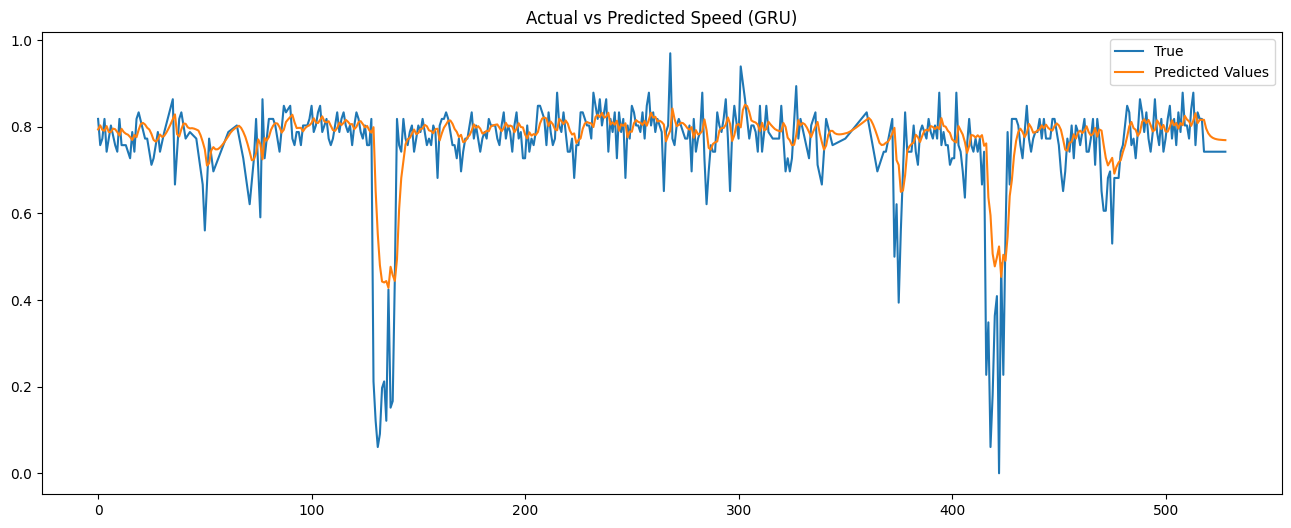

In [41]:
#Speed data
#Analyze the model's performance with RMSE and MAE using the test data
ys_pred_GRU = modelGRU_s.predict(Xs_test)
rmse = np.sqrt(mean_squared_error(ys_test, ys_pred_GRU))
mae = mean_absolute_error(ys_test, ys_pred_GRU)
print('RMSE:', rmse)
print('MAE:', mae)

#visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16, 6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_GRU.flatten(), label='Predicted Values')
plt.title('Actual vs Predicted Speed (GRU)')
plt.legend()
plt.show()

17/17 [==============================] - 1s 28ms/step
RMSE: 0.08538934879806993
MAE: 0.05323302013188979


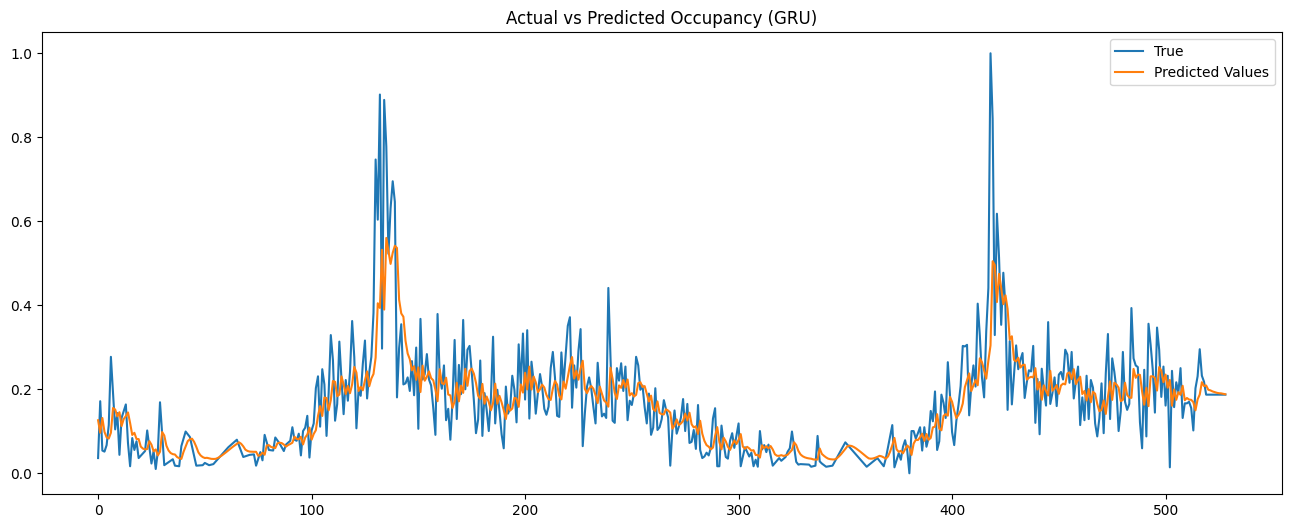

In [43]:
#Occcupancy data
#Analyze the model's performance with RMSE and MAE using the test data
yo_pred_GRU = modelGRU_o.predict(Xo_test)
rmse = np.sqrt(mean_squared_error(yo_test, yo_pred_GRU))
mae = mean_absolute_error(yo_test, yo_pred_GRU)
print('RMSE:', rmse)
print('MAE:', mae)

#visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16, 6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_GRU.flatten(), label='Predicted Values')
plt.title('Actual vs Predicted Occupancy (GRU)')
plt.legend()
plt.show()

17/17 [==============================] - 1s 29ms/step
RMSE: 0.015012671660620818
MAE: 0.009218585099088659


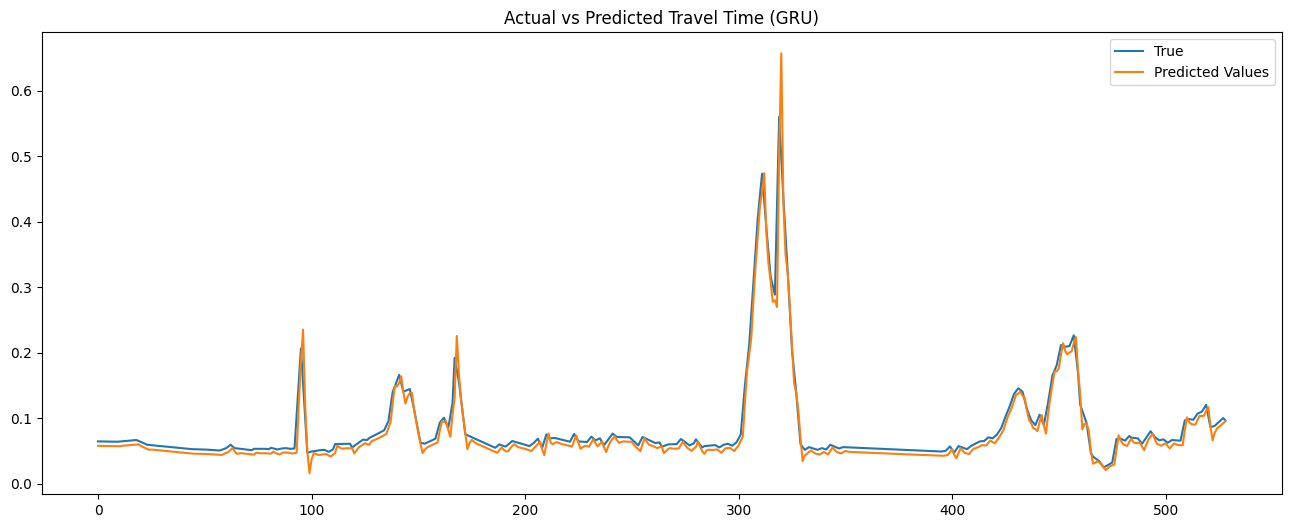

In [45]:
#Travel time data
#Analyze the model's performance with RMSE and MAE using the test data
yt_pred_GRU = modelGRU_tt.predict(Xt_test)
rmse = np.sqrt(mean_squared_error(yt_test, yt_pred_GRU))
mae = mean_absolute_error(yt_test, yt_pred_GRU)
print('RMSE:', rmse)
print('MAE:', mae)

#visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16, 6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_GRU.flatten(), label='Predicted Values')
plt.title('Actual vs Predicted Travel Time (GRU)')
plt.legend()
plt.show()